# Hamiltonian Monte Carlo

Having introduced first-generation MCMC methods previously, we will now turn our attention to a more sophisticated class of algorithm, which improve upon random-walk jump algorithms by using information about the posterior distribution to inform candidate transitions: namely, gradient information.

In order to implement these methods in code, we require more powerful mathematical software tools that allow for automated gradient calculation. There are several open source toolboxes that can support gradient-based Monte Carlo methods, and we will look at one of them in detail.

## Introduction to Mathematical Expressions with Theano

Theano is a Python library that allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently. Theano features:

* __tight integration with numpy__ – Use numpy.ndarray in Theano-compiled functions.
* __transparent use of a GPU__ – Perform data-intensive calculations up to 140x faster than with CPU.(float32 only)
* __efficient symbolic differentiation__ – Theano does your derivatives for function with one or many inputs.
* __speed and stability optimizations__ – Get the right answer for log(1+x) even when x is really tiny.
* __dynamic C code generation__ – Evaluate expressions faster.
* __extensive unit-testing and self-verification__ – Detect and diagnose errors.

Theano is part programming language, part compiler. It is often used to build machine learning, though it is not in itself a machine learning toolkit; think of it as a **mathematical toolkit**.

After a brief introduction to the Theano package, we will use it to implement a modern MCMC algorithm, *Hamiltonian Monte Carlo (HMC)*.

## Adding Two Scalars

To get us started with Theano and get a feel of what we're working with, 
let's make a simple function: add two numbers together. Here is how you do
it:

### Step 1 - Declaring Variables

In [1]:
import numpy as np

from theano import function, shared
import theano.tensor as tt
import theano

x = tt.dscalar('x')
y = tt.dscalar('y')

In Theano, all symbols must be typed. In particular, `tt.dscalar`
is the type we assign to "0-dimensional arrays (`scalar`) of doubles
(`d`)". It is a Theano `type`.

In [2]:
type(x)

theano.tensor.var.TensorVariable

In [3]:
x.type

TensorType(float64, scalar)

In [4]:
tt.dscalar

TensorType(float64, scalar)

Notice that we have created objects of the type `TensorVariable`. A **tensor** is a generalization of an array to (potentially) multiple dimensions. Thus, everything from a scalar to a 5-dimensional hyper-matrix can be accomodated with the same abstraction. All expressions defined in Theano are performed by associating tensors with operations and with one another.

### Step 2 - Symbolic Expressions

The second step is to combine *x* and *y* into their sum *z*:

In [5]:
z = x + y

*z* is yet another *Variable* which represents the addition of
*x* and *y*. You can use the `pp` function to *pretty-print* out the computation associated to *z*.


In [6]:
from theano.printing import pp
print(pp(z))

(x + y)


### Step 3 - Compiling a Function

The last step is to create a function taking *x* and *y* as inputs
and giving *z* as output:

In [7]:
f = function([x, y], z)

The first argument to `function()` is a list of Variables
that will be provided as inputs to the function. The second argument
is a single Variable *or* a list of Variables. For either case, the second
argument is what we want to see as output when we apply the function. *f* may
then be used like a normal Python function.


Now we can call the function:

In [8]:
print(f(2, 3))

5.0


In [9]:
print(f(16.3, 12.1))

28.4


If you are following along and typing into an interpreter, you may have
noticed that there was a slight delay in executing the ``function``
instruction. Behind the scenes, *f* was being **compiled into C code**.

Internally, Theano builds a graph structure composed of interconnected `Variable` nodes, `op` nodes and `apply` nodes. 

An `op` node encapsulates a particular mathematical operation, such as an arithmetic operation or a transformation.

An `apply` node represents the application of an `op` to some variables. It is important to draw the difference between the definition of a computation represented by an `op` and its application to some actual data which is represented by the apply node. 

A `Variable` is the main data structure you work with when
using Theano. By calling `tt.dscalar` with a string argument, you create a
`Variable` representing a floating-point scalar quantity with the
given name. If you provide no argument, the symbol will be unnamed. Names
are not required, but they can help debugging.

## Adding Two Matrices

If we want to work with matrices instead of scalars, the only change
from the previous example is that you need to instantiate *x* and
*y* using the matrix Types:

In [10]:
x = tt.dmatrix('x')
y = tt.dmatrix('y')
z = x + y
f = function([x, y], z)

Here is the expression graph corresponding to the addition of `x` and `y`:

![expression graph](images/expression_graph.png)

``dmatrix`` is the Type for matrices of doubles. Then we can use
our new function on 2D arrays:


In [11]:
f([[1, 2], [3, 4]], [[10, 20], [30, 40]])

array([[ 11.,  22.],
       [ 33.,  44.]])

The following types are available:

* **byte**: ``bscalar, bvector, bmatrix, brow, bcol, btensor3, btensor4``
* **16-bit integers**: ``wscalar, wvector, wmatrix, wrow, wcol, wtensor3, wtensor4``
* **32-bit integers**: ``iscalar, ivector, imatrix, irow, icol, itensor3, itensor4``
* **64-bit integers**: ``lscalar, lvector, lmatrix, lrow, lcol, ltensor3, ltensor4``
* **float**: ``fscalar, fvector, fmatrix, frow, fcol, ftensor3, ftensor4``
* **double**: ``dscalar, dvector, dmatrix, drow, dcol, dtensor3, dtensor4``
* **complex**: ``cscalar, cvector, cmatrix, crow, ccol, ctensor3, ctensor4``

An example of a slightly more interesting function is the logistic curve:

In [12]:
x = tt.dmatrix('x')

The logistic transformation:

In [13]:
s = 1 / (1 + tt.exp(-x))

In [14]:
logistic = function([x], s)
print(logistic([[0, 1], [-1, -2]]))

[[ 0.5         0.73105858]
 [ 0.26894142  0.11920292]]


Theano supports functions with multiple outputs. For example, we can
compute the elementwise difference, absolute difference, and
squared difference between two matrices *a* and *b* at the same time.

In [15]:
a, b = tt.dmatrices('a', 'b')
diff = a - b
abs_diff = abs(diff)
diff_squared = diff ** 2

When we use the function `f`, it returns the three computed results as a list.

In [16]:
f = function([a, b], [diff, abs_diff, diff_squared])

f([[1, 1], [1, 1]], [[0, 1], [2, 3]])

[array([[ 1.,  0.],
        [-1., -2.]]), array([[ 1.,  0.],
        [ 1.,  2.]]), array([[ 1.,  0.],
        [ 1.,  4.]])]

## Setting a Default Value for an Argument
 
Let's say you want to define a function that adds two numbers, except that if you only provide one number, the other input is assumed to be one. In Python, the default value for parameters achieves this effect.

In Theano we make use of the [In](http://deeplearning.net/software/theano/library/compile/io.html#function-inputs) class, which allows you to specify properties of your function's parameters with greater detail. Here we give a default value of 1 for y by creating an In instance with its value field set to 1. Inputs with default values must follow inputs without default values (like Python's functions). There can be multiple inputs with default values. These parameters can be set positionally or by name, as in standard Python.

In [17]:
from theano import In

x, y, w = tt.dscalars('x', 'y', 'w')
z = (x + y) * w
g = function([x, In(y, value=1), In(w, value=2, name='w_by_name')], z)

In [18]:
print('g(33) = {}'.format(g(33)))

g(33) = 68.0


In [19]:
print('g(33, 0, 1) = {}'.format(g(33, 0, 1)))

g(33, 0, 1) = 33.0


In [20]:
print('g(33, w_by_name=1) = {}'.format(g(33, w_by_name=1)))

g(33, w_by_name=1) = 34.0


## Maintaining State with Shared Variables

It is also possible to make a function with an internal state. For example, let’s say we want to make an accumulator: at the beginning, the state is initialized to zero. Then, on each function call, the state is incremented by the function’s argument.

First let’s define the accumulator function. It adds its argument to the internal state, and returns the old state value.

In [21]:
state = shared(0)
inc = tt.iscalar('inc')
accumulator = function([inc], state, updates=[(state, state+inc)])

This code introduces a few new concepts. The `shared` function constructs so-called shared variables. 

    state = shared(0)

These are hybrid symbolic and non-symbolic variables whose value may be shared between multiple functions. Shared variables can be used in symbolic expressions but they also have an internal value that defines the value taken by this symbolic variable in all the functions that use it. It is called a shared variable because its value is shared between many functions. The value can be accessed and modified by the `get_value` and `set_value` methods.

The other new thing in this code is the `updates` parameter of function. 

    updates=[(state, state+inc)

`updates` must be supplied with a list of pairs of the form `(shared-variable, new expression)`. It can also be a dictionary whose keys are shared-variables and values are the new expressions. Here, the accumulator replaces the `state`‘s value with the sum of `state` and the increment amount `inc`.

In [22]:
print(state.get_value())

0


In [23]:
print(accumulator(1))

0


In [24]:
print(state.get_value())

1


In [25]:
print(accumulator(300))

1


In [26]:
print(state.get_value())

301


It is possible to reset the state. Just use the `set_value` method:

In [27]:
state.set_value(-1)

In [28]:
print(accumulator(3))

-1


In [29]:
print(state.get_value())

2


As we mentioned above, you can define more than one function to use the same shared variable. These functions can all update the value.

In [30]:
decrementor = function([inc], state, updates=[(state, state-inc)])

In [31]:
print(decrementor(2))

2


In [32]:
print(state.get_value())

0


You might be wondering why the updates mechanism exists. You can always achieve a similar result by returning the new expressions, and working with them in NumPy as usual. While the updates mechanism can be a syntactic convenience, it is mainly there for *efficiency*. Updates to shared variables can sometimes be done more quickly using in-place algorithms (e.g. low-rank matrix updates). Also, Theano has more control over where and how shared variables are allocated, which is one of the important elements of getting good performance on the GPU.

### Exercise: Create and manipulate Theano objects

To give you some practice with basic Theano data structures and functions, try making the operations below work by implementing the functions that are needed.

In [ ]:
def make_vector():
    """
    Create and return a new Theano vector.
    """

    pass

def make_matrix():
    """
    Create and return a new Theano matrix.
    """

    pass

def elemwise_mul(a, b):
    """
    a: A theano matrix
    b: A theano matrix
    
    Calcuate the elementwise product of a and b and return it
    """

    pass

def matrix_vector_mul(a, b):
    """
    a: A theano matrix
    b: A theano vector
    
    Calculate the matrix-vector product of a and b and return it
    """

    pass

a = make_vector()
b = make_vector()
c = elemwise_mul(a, b)
d = make_matrix()
e = matrix_vector_mul(d, c)

f = function([a, b, d], e)

rng = np.random.RandomState([1, 2, 3])
a_value = rng.randn(5).astype(a.dtype)
b_value = rng.rand(5).astype(b.dtype)
c_value = a_value * b_value
d_value = rng.randn(5, 5).astype(d.dtype)
expected = np.dot(d_value, c_value)

actual = f(a_value, b_value, d_value)

assert np.allclose(actual, expected)
print("SUCCESS!")

### Example: Logistic regression

Here is a non-trivial example, which uses Theano to estimate the parameters of a logistic regression model using gradient information. We will use the bioassay example as a test case:

In [34]:
rng = np.random

dose = np.array([-0.86, -0.3 , -0.05,  0.73])
deaths = np.array([0, 1, 3, 5])
training_steps = 1000

We first declare Theano symbolic variables:

In [35]:
x = tt.vector("x")
y = tt.vector("y")
w = theano.shared(1., name="w")
b = theano.shared(0., name="b")

print("Initial model:", w.get_value(), b.get_value())

Initial model: 1.0 0.0


... then construct the expression graph:

In [36]:
# Probability that target = 1
p_1 = 1 / (1 + tt.exp(-(x*w + b))) 

# The prediction threshold
prediction = p_1 > 0.5         

# Cross-entropy loss function
xent = -y * tt.log(p_1) - (5-y) * tt.log(1-p_1) 

# The cost to minimize
cost = xent.mean()      

# Compute the gradient of the cost
gw, gb = tt.grad(cost, [w, b])                  

Compile Theano functions:

In [37]:
step = theano.shared(10., name='step')
train = theano.function(
          inputs=[x, y],
          outputs=[prediction, xent],
          updates=((w, w - step * gw), (b, b - step * gb), (step, step * 0.99)))
predict = theano.function(inputs=[x], outputs=prediction)

Train model:

In [38]:
for i in range(training_steps):
    pred, err = train(dose, deaths)
    
w, b = w.get_value(), b.get_value()

print("Final model:", w, b)

Final model: 7.795152457520207 0.8536420249656105


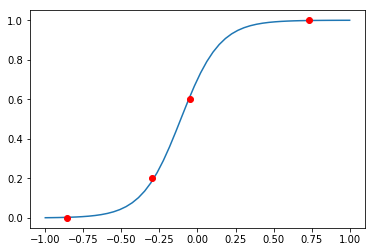

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

logit = lambda x: 1. / (1 + np.exp(-x))
xvals = np.linspace(-1, 1)
plt.plot(xvals, logit(w*xvals + b))
plt.plot(dose, deaths/5., 'ro')

## Exercises: Gradients and functions

Let's try using the Theano automatic gradient system to compute derivatives.

In [ ]:
def grad_sum(x, y, z):
    """
    x: A theano variable
    y: A theano variable
    z: A theano expression involving x and y
    Returns dz / dx + dz / dy
    """

    pass


x = tt.scalar()
y = tt.scalar()
z = x + y
s = grad_sum(x, y, z)
assert s.eval({x: 0, y: 0}) == 2
print("SUCCESS!")

Now try compiling and running a simple function:

In [ ]:
def evaluate(x, y, expr, x_value, y_value):
    """
    x: A theano variable
    y: A theano variable
    expr: A theano expression involving x and y
    x_value: A numpy value
    y_value: A numpy value
    
    Returns the value of expr when x_value is substituted for x
    and y_value is substituted for y
    """

    pass


x = tt.iscalar()
y = tt.iscalar()
z = x + y
assert evaluate(x, y, z, 1, 2) == 3
print("SUCCESS!")

### Random Numbers

Because in Theano you first express everything symbolically and afterwards compile this expression to get functions, using pseudo-random numbers is not as straightforward as it is in NumPy.

The way to think about putting randomness into Theano’s computations is to put random variables in your graph. Theano will allocate a NumPy `RandomStream` object (a random number generator) for each such variable, and draw from it as necessary. We will call this sort of sequence of random numbers a random stream. Random streams are at their core shared variables, so the observations on shared variables hold here as well. 

In [40]:
from theano.tensor.shared_randomstreams import RandomStreams

srng = RandomStreams(seed=234)
rv_u = srng.uniform((2,2))
f = function([], rv_u)

In [41]:
f()

array([[ 0.12672381,  0.97091597],
       [ 0.13989098,  0.88754825]])

## Looping in Theano

The `scan` function provides the ability to write loops in Theano. We are not able to use Python `for` loops with Theano because Theano needs to be able to build and optimize the expression graph before compiling it into faster code, and be able to use symbolic differentiation for calculating gradients.

### Simple loop with accumulation

Assume that, given $k$ you want to get $A^k$ using a loop. More precisely, if $A$ is a tensor you want to compute $A^k$ elementwise. The python code might look like:

```python
result = 1
for i in range(k):
  result = result * A
```

There are three things here that we need to handle: the initial value assigned to result, the accumulation of results in result, and the unchanging variable A. Unchanging variables are passed to scan as non_sequences. Initialization occurs in outputs_info, and the accumulation happens automatically.

The equivalent Theano code would be:

In [42]:
k = tt.iscalar("k")
A = tt.vector("A")

# Symbolic description of the result
result, updates = theano.scan(fn=lambda prior_result, A: prior_result * A,
                              outputs_info=tt.ones_like(A),
                              non_sequences=A,
                              n_steps=k)

# We only care about A**k, but scan has provided us with A**1 through A**k.
# Discard the values that we don't care about. Scan is smart enough to
# notice this and not waste memory saving them.
final_result = result[-1]

# compiled function that returns A**k
power = theano.function(inputs=[A,k], outputs=final_result, updates=updates)

print(power(range(10),2))
print(power(range(10),4))

[  0.   1.   4.   9.  16.  25.  36.  49.  64.  81.]
[  0.00000000e+00   1.00000000e+00   1.60000000e+01   8.10000000e+01
   2.56000000e+02   6.25000000e+02   1.29600000e+03   2.40100000e+03
   4.09600000e+03   6.56100000e+03]


Let us go through the example line by line. What we did is first to **construct a function** (using a lambda expression) that given `prior_result` and `A` returns `prior_result * A`. The order of parameters is fixed by `scan`: the output of the prior call to `fn` is the first parameter, followed by all non-sequences.

Next we **initialize the output** as a tensor with same shape and `dtype` as `A`, filled with ones. We give `A` to `scan` as a non sequence parameter and specify the number of steps `k` to iterate over our `lambda` expression.

Scan **returns a tuple** containing our result (`result`) and a dictionary of updates (empty in this case). Note that the result is not a matrix, but a 3D tensor containing the value of $A^k$ for each step. We want the last value (after k steps) so we compile a function to return just that. Note that there is an optimization, that at compile time will detect that you are using just the last value of the result and ensure that scan does not store all the intermediate values that are used. So do not worry if `A` and `k` are large.

In addition to looping a fixed number of times, scan can iterate over the leading dimension of tensors (similar to Python’s `for x in a_list`).

The tensor(s) to be looped over should be provided to `scan` using the `sequences` keyword argument.

### Example: polynomial calculation

Here’s an example that builds a symbolic calculation of a polynomial from a list of its coefficients:

In [43]:
coefficients = theano.tensor.vector("coefficients")
x = tt.scalar("x")

# Generate the components of the polynomial
components, updates = theano.scan(fn=lambda coefficient, power, val: coefficient * (val ** power),
                                  outputs_info=None,
                                  sequences=[coefficients, theano.tensor.arange(1000)],
                                  non_sequences=x)
# Sum them up
polynomial = components.sum()

# Compile a function
calculate_polynomial = theano.function(inputs=[coefficients, x], outputs=polynomial)

# Test
test_coefficients = np.asarray([1, 0, 2], dtype=np.float32)
test_value = 3
print(calculate_polynomial(test_coefficients, test_value))

19.0


## Hamiltonian Monte Carlo

While flexible and easy to implement, Metropolis-Hastings sampling is a random walk
sampler that might not be statistically efficient for many models. Specifically, for models of high dimension, random walk jumping algorithms do not perform well. It is not enough to simply guess at the next sample location; we need to make each iteration a useful draw from the posterior whenever we can, in order to have an efficient sampler for bigger models.

Since Bayesian inference is all about calculating expectations over posteriors, what we seek is an algorithm that explores the area of the parameter space that contains most of the non-zero probability. This region is called the **typical set**.



### What's a Typical Set?

The typical set is where most of the probability density (mass) lies in a particular volume associated with the distribution. As the dimension of a model increases, this set moves progressively further from the mode, and becomes more singular, as the result of concentration of measure.

The typical set is a product of both the density, which is highest at the mode, and volume (that we integrate over), which increasingly becomes larger away from the mode as dimensionality increases. In fact, at high dimensions, the region around the mode contributes almost nothing to the expectation. We need an algorithm that will find this narrow region and explore it efficiently.

![from Hoffman and Gelman 2014](http://d.pr/i/RAA+)

In this context, and when sampling from continuous variables, Hamiltonian (or Hybrid) Monte
Carlo (HMC) can prove to be a powerful tool. It avoids
random walk behavior by simulating a physical system governed by
Hamiltonian dynamics, potentially avoiding tricky conditional
distributions in the process.

In HMC, model samples are obtained by simulating a physical system,
where particles move about a high-dimensional landscape, subject to
potential and kinetic energies. Adapting the notation from [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html),
particles are characterized by a position vector or state
$s \in \mathcal{R}^D$ and velocity vector $\phi \in \mathcal{R}^D$. The
combined state of a particle is denoted as $\chi=(s,\phi)$. 

The joint **canonical distribution** of the position and velocity can be expressed as a product of the marginal position (which is of interest) and the conditional distribution of the velocity:

$$\pi(s, \phi) = \pi(\phi | s) \pi(s)$$

This joint probability can also be written in terms of an invariant **Hamiltonian function**:

$$\pi(s, \phi) \propto \exp(-H(s,\phi))$$

The Hamiltonian is then defined as the sum of potential energy $E(s)$ and kinetic energy
$K(\phi)$, as follows:

$$\mathcal{H}(s,\phi) = E(s) + K(\phi)
= E(s) + \frac{1}{2} \sum_i \phi_i^2$$

Instead of sampling $p(s)$ directly, HMC operates by sampling from the canonical distribution.

$$p(s,\phi) = \frac{1}{Z} \exp(-\mathcal{H}(s,\phi))=p(s)p(\phi)$$.

If we choose a momentum that is independent of position, marginalizing over $\phi$ is
trivial and recovers the original distribution of interest.

Note that the Hamiltonian $\mathcal{H}$ is independent of the parameterization of the model, and therefore, captures the geometry of the phase space distribution, including typical set. 

**Hamiltonian Dynamics**

State $s$ and velocity $\phi$ are modified such that
$\mathcal{H}(s,\phi)$ remains constant throughout the simulation. The
differential equations are given by:

$$\begin{aligned}\frac{ds_i}{dt} &= \frac{\partial \mathcal{H}}{\partial \phi_i} = \phi_i \\
\frac{d\phi_i}{dt} &= - \frac{\partial \mathcal{H}}{\partial s_i}
= - \frac{\partial E}{\partial s_i}
\end{aligned}$$

As shown in [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html), 
the above transformation preserves volume and is
reversible. The above dynamics can thus be used as transition operators
of a Markov chain and will leave $p(s,\phi)$ invariant. That chain by
itself is not ergodic however, since simulating the dynamics maintains a
fixed Hamiltonian $\mathcal{H}(s,\phi)$. HMC thus alternates Hamiltonian
dynamic steps, with Gibbs sampling of the velocity. Because $p(s)$ and
$p(\phi)$ are independent, sampling $\phi_{new} \sim p(\phi|s)$ is
trivial since $p(\phi|s)=p(\phi)$, where $p(\phi)$ is often taken to be
the univariate Gaussian.

**The Leap-Frog Algorithm**

In practice, we cannot simulate Hamiltonian dynamics exactly because of
the problem of time discretization. There are several ways one can do
this. To maintain invariance of the Markov chain however, care must be
taken to preserve the properties of *volume conservation* and *time
reversibility*. The **leap-frog algorithm** maintains these properties
and operates in 3 steps:

$$\begin{aligned}
\phi_i(t + \epsilon/2) &= \phi_i(t) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\phi_i(t + \epsilon) &= \phi_i(t + \epsilon/2) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + \epsilon)) 
\end{aligned}$$

We thus perform a half-step update of the velocity at time
$t+\epsilon/2$, which is then used to compute $s(t + \epsilon)$ and
$\phi(t + \epsilon)$.

**Accept / Reject**

In practice, using finite stepsizes $\epsilon$ will not preserve
$\mathcal{H}(s,\phi)$ exactly and will introduce bias in the simulation.
Also, rounding errors due to the use of floating point numbers means
that the above transformation will not be perfectly reversible.

HMC cancels these effects **exactly** by adding a Metropolis
accept/reject stage, after $n$ leapfrog steps. The new state
$\chi' = (s',\phi')$ is accepted with probability $p_{acc}(\chi,\chi')$,
defined as:

$$p_{acc}(\chi,\chi') = min \left( 1, \frac{\exp(-\mathcal{H}(s',\phi')}{\exp(-\mathcal{H}(s,\phi)} \right)$$

**HMC Algorithm**

We obtain a new HMC sample as follows:

1.  sample a new velocity from a univariate Gaussian distribution
2.  perform $n$ leapfrog steps to obtain the new state $\chi'$
3.  perform accept/reject move of $\chi'$

Implementing HMC Using Theano
-----------------------------

In Theano, update dictionaries and shared variables provide a natural
way to implement a sampling algorithm. The current state of the sampler
can be represented as a Theano shared variable, with HMC updates being
implemented by the updates list of a Theano function.

We breakdown the HMC algorithm into the following sub-components:

-   `simulate_dynamics`: a symbolic Python function which, given an
    initial position and velocity, will perform `n_steps` leapfrog
    updates and return the symbolic variables for the proposed state
    $\chi'$.
-   `hmc_move`: a symbolic Python function which given a starting
    position, generates $\chi$ by randomly sampling a velocity vector.
    It then calls `simulate_dynamics` and determines whether the
    transition $\chi
    \rightarrow \chi'$ is to be accepted.
-   `hmc_updates`: a Python function which, given the symbolic
    outputs of `hmc_move`, generates the list of updates for a single
    iteration of HMC.
-   `HMC_sampler`: a Python helper class which wraps everything
    together.

**simulate\_dynamics**

To perform $n$ leapfrog steps, we first need to define a function over
which the algorithm can iterate. Instead of implementing leap frog verbatim, notice that we can obtain
$s(t + n \epsilon)$ and $\phi(t + n \epsilon)$ by performing an initial
half-step update for $\phi$, followed by $n$ full-step updates for
$s,\phi$ and one last half-step update for $\phi$. In loop form, this
gives:

$$\begin{aligned}\phi_i(t + \epsilon/2) &= \phi_i(t) -
\frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\text{For } m \in [2,n]\text{, perform full updates: } \\
\qquad
\phi_i(t + (m - 1/2)\epsilon) &= \phi_i(t + (m-3/2)\epsilon) -
\epsilon \frac{\partial{}}{\partial s_i} E(s(t + (m-1)\epsilon)) \\
\qquad
s_i(t + m\epsilon) &= s_i(t) + \epsilon \phi_i(t + (m-1/2)\epsilon) \\
\phi_i(t + n\epsilon) &= \phi_i(t + (n-1/2)\epsilon) -
\frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + n\epsilon)) 
\end{aligned}$$

The inner-loop defined above is implemented by the following
`leapfrog` function, with `pos`, `vel` and `step` replacing
$s,\phi$ and $\epsilon$ respectively.

```python
def leapfrog(pos, vel, step):

    # one full velocity step
    dE_dpos = tt.grad(energy_fn(pos).sum(), pos)
    new_vel = vel - step * dE_dpos
    
    # one full position step
    new_pos = pos + step * new_vel

    return [new_pos, new_vel],{}
```

The `simulate_dynamics` function performs the full algorithm. We start with the initial half-step update of $\phi$
and full-step of $s$, and then scan over the `leapfrog` method `n_steps-1` times.

In [44]:
def simulate_dynamics(initial_pos, initial_vel, stepsize, n_steps, energy_fn):
    

    def leapfrog(pos, vel, step):

        # Gradient calculation
        dE_dpos = tt.grad(energy_fn(pos).sum(), pos)
        
        new_vel = vel - step * dE_dpos
        new_pos = pos + step * new_vel
        return [new_pos, new_vel], {}

    # An initial half-step in velocity
    initial_energy = energy_fn(initial_pos)
    dE_dpos = tt.grad(initial_energy.sum(), initial_pos)
    vel_half_step = initial_vel - 0.5 * stepsize * dE_dpos

    # ... followed by one full position step
    pos_full_step = initial_pos + stepsize * vel_half_step

    # Perform full velocity-step updates afterwards, using scan
    (all_pos, all_vel), scan_updates = theano.scan(leapfrog,
            outputs_info=[
                dict(initial=pos_full_step),
                dict(initial=vel_half_step),
                ],
            non_sequences=[stepsize],
            n_steps=n_steps - 1)
    
    # Our final position after integrating
    final_pos = all_pos[-1]
    final_vel = all_vel[-1]
    
    # One final half-step in velocity to complete the algorithm
    energy = energy_fn(final_pos)
    final_vel = final_vel - 0.5 * stepsize * tt.grad(energy.sum(), final_pos)

    # return new proposal state
    return final_pos, final_vel

A final half-step is performed to compute $\phi(t+n\epsilon)$, and the
final proposed state $\chi'$ is returned.

**hmc_move**

The `hmc_move` function implements the remaining steps (steps 1 and
3) of an HMC move proposal (while wrapping the `simulate_dynamics`
function). Given a matrix of initial states
$s \in \mathcal{R}^{N \times D}$ (`positions`) and energy function
$E(s)$ (`energy_fn`), it defines the symbolic graph for computing
`n_steps` of HMC, using a given `stepsize`. The function prototype
is as follows:

In [45]:
def hmc_move(s_rng, positions, energy_fn, stepsize, n_steps):

    # sample random velocity using independent normals
    initial_vel = s_rng.normal(size=positions.shape)

    # perform simulation of particles subject to Hamiltonian dynamics
    final_pos, final_vel = simulate_dynamics(
            initial_pos=positions,
            initial_vel=initial_vel,
            stepsize=stepsize,
            n_steps=n_steps,
            energy_fn=energy_fn)

    # accept/reject the proposed move based on the joint distribution
    accept = metropolis_hastings_accept(
            energy_prev=hamiltonian(positions, initial_vel, energy_fn),
            energy_next=hamiltonian(final_pos, final_vel, energy_fn),
            s_rng=s_rng)

    return accept, final_pos

We start by sampling **random velocities**, using the provided shared
`RandomStream` object. Velocities are sampled independently for each
dimension and for each particle under simulation, yielding a
$N \times D$ matrix.

    initial_vel = s_rng.normal(size=positions.shape)
    
Since we now have an initial position and velocity, we can now call the
`simulate_dynamics` to obtain the proposal for the new state $\chi'$.

    final_pos, final_vel = simulate_dynamics(
            initial_pos = positions, 
            initial_vel = initial_vel,
            stepsize = stepsize,
            n_steps = n_steps,
            energy_fn = energy_fn)
            
We then **accept/reject** the proposed state based on the Metropolis
algorithm.

    accept = metropolis_hastings_accept(
            energy_prev=hamiltonian(positions, initial_vel, energy_fn),
            energy_next=hamiltonian(final_pos, final_vel, energy_fn),
            s_rng=s_rng)
            
where `metropolis_hastings_accept` and `hamiltonian` are helper
functions, defined as follows.

In [46]:
def metropolis_hastings_accept(energy_prev, energy_next, s_rng):
    
    ediff = energy_prev - energy_next
    return (tt.exp(ediff) - s_rng.uniform(size=energy_prev.shape)) >= 0


def kinetic_energy(vel):
    
    return 0.5 * (vel ** 2).sum(axis=1)


def hamiltonian(pos, vel, energy_fn):
    """
    Returns the Hamiltonian (sum of potential and kinetic energy) for the given
    velocity and position. Assumes mass is 1.
    """
    return energy_fn(pos) + kinetic_energy(vel)

`hmc_move` finally returns the tuple `(accept, final_pos)`.
`accept` is a symbolic boolean variable indicating whether or not the
new state `final_pos` should be used or not.

**hmc_updates**

The purpose of `hmc_updates` is to generate the **list of updates** to
perform, whenever our HMC sampling function is called. `hmc_updates`
thus receives as parameters, a series of shared variables to update
(`positions`, `stepsize` and `avg_acceptance_rate`), and the
parameters required to compute their new state.

    def hmc_updates(positions, stepsize, avg_acceptance_rate, final_pos, 
            accept, target_acceptance_rate, stepsize_inc, stepsize_dec, 
            stepsize_min, stepsize_max, avg_acceptance_slowness):
    
    
        accept_matrix = accept.dimshuffle(0, *(('x',) * (final_pos.ndim - 1)))
        
        new_positions = tt.switch(accept_matrix, final_pos, positions)
        
Using the above code, the dictionary `{positions: new_positions}` can
be used to update the state of the sampler with either (1) the new state
`final_pos` if `accept` is True, or (2) the old state if `accept`
is False. This conditional assignment is performed by Theano's
[switch](http://deeplearning.net/software/theano/library/tensor/basic.html#tensor.switch)
function.

`switch` expects as its first argument, a boolean mask with the same
broadcastable dimensions as the second and third argument. Since
`accept` is scalar-valued, we must first use
[dimshuffle](http://deeplearning.net/software/theano/library/tensor/basic.html#tensor._tensor_py_operators.dimshuffle)
to permute the dimensions so that it is of the appropriate
dimensions for broadcasting.

`hmc_updates` additionally implements an *adaptive* version of HMC. We start by
tracking the average acceptance rate of the HMC move proposals (across
many simulations), using an exponential moving average with time
constant `1 - avg_acceptance_slowness`.

    new_acceptance_rate = tt.add(
            avg_acceptance_slowness * avg_acceptance_rate,
            (1.0 - avg_acceptance_slowness) * accept.mean())
            
If the average acceptance rate is larger than the
`target_acceptance_rate`, we increase the `stepsize` by a factor
of `stepsize_inc` in order to increase the mixing rate of our chain.
If the average acceptance rate is too low however, `stepsize` is
decreased by a factor of `stepsize_dec`, yielding a more conservative
mixing rate.

    _new_stepsize = tt.switch(avg_acceptance_rate > target_acceptance_rate,
                              stepsize * stepsize_inc, stepsize * stepsize_dec)

    new_stepsize = tt.clip(_new_stepsize, stepsize_min, stepsize_max)

The
[`clip`](http://deeplearning.net/software/theano/library/tensor/basic.html#tensor.clip)
function allows us to maintain the `stepsize` in the range
[`stepsize_min`, `stepsize_max`].

The final updates list is then returned:

    return [(positions, new_positions),
        (stepsize, new_stepsize),
        (avg_acceptance_rate, new_acceptance_rate)]

In [47]:
def hmc_updates(positions, stepsize, avg_acceptance_rate, final_pos, accept,
                 target_acceptance_rate, stepsize_inc, stepsize_dec,
                 stepsize_min, stepsize_max, avg_acceptance_slowness):

    """
    POSITION UPDATES
    
    Uses results of the acceptance test to update position
    """

    accept_matrix = accept.dimshuffle(0, *(('x',) * (final_pos.ndim - 1)))
    # if accept is True, update to `final_pos` else stay put
    new_positions = tt.switch(accept_matrix, final_pos, positions)

    """
    STEP SIZE UPDATES
    
    If the acceptance rate is two low, reduce the stepsize; if it is too high, 
    increase the stepsize
    """
    
    _new_stepsize = tt.switch(avg_acceptance_rate > target_acceptance_rate,
                              stepsize * stepsize_inc, stepsize * stepsize_dec)
    # maintain stepsize in [stepsize_min, stepsize_max]
    new_stepsize = tt.clip(_new_stepsize, stepsize_min, stepsize_max)

    # Update acceptance rate with exponential moving average
    mean_dtype = theano.scalar.upcast(accept.dtype, avg_acceptance_rate.dtype)
    new_acceptance_rate = tt.add(
            avg_acceptance_slowness * avg_acceptance_rate,
            (1.0 - avg_acceptance_slowness) * accept.mean(dtype=mean_dtype))

    return [(positions, new_positions),
            (stepsize, new_stepsize),
            (avg_acceptance_rate, new_acceptance_rate)]

**HMC_sampler**

We implement the sampler in a Python class, called `HMC_Sampler`. It is a convenience wrapper for performing Hybrid Monte Carlo (HMC). It creates the symbolic graph for performing an HMC simulation (using `hmc_move` and `hmc_updates`). The graph is then compiled into the `simulate` function, a theano function which runs the simulation and updates the required shared
variables. Its main attributes are:

-   `new_from_shared_positions`: a constructor method which
    allocates various shared variables and strings together the calls to
    `hmc_move` and `hmc_updates`. It also builds the theano
    function `simulate`, whose sole purpose is to execute the updates
    generated by `hmc_updates`.
-   `draw`: a convenience method which calls the Theano function
    `simulate` and returns a copy of the contents of the shared
    variable `self.positions`.

In [48]:
sharedX = lambda X, name: \
        shared(np.asarray(X, dtype=theano.config.floatX), name=name)

class HMC(object):

    def __init__(self, shared_positions, energy_fn,
            initial_stepsize=0.01, target_acceptance_rate=.9, n_steps=20,
            stepsize_dec=0.98,
            stepsize_min=0.001,
            stepsize_max=0.25,
            stepsize_inc=1.02,
            avg_acceptance_slowness=0.9,
            seed=12345):
        
        self.positions = shared_positions
        
        batchsize = shared_positions.shape[0]

        # allocate shared variables
        self.stepsize = stepsize = sharedX(initial_stepsize, 'hmc_stepsize')
        self.avg_acceptance_rate = avg_acceptance_rate = sharedX(target_acceptance_rate,
                                      'avg_acceptance_rate')
        
        s_rng = tt.shared_randomstreams.RandomStreams(seed)

        # define graph for an `n_steps` HMC simulation
        accept, final_pos = hmc_move(
                s_rng,
                shared_positions,
                energy_fn,
                stepsize,
                n_steps)

        # define the dictionary of updates, to apply on every `simulate` call
        simulate_updates = hmc_updates(
                shared_positions,
                stepsize,
                avg_acceptance_rate,
                final_pos=final_pos,
                accept=accept,
                stepsize_min=stepsize_min,
                stepsize_max=stepsize_max,
                stepsize_inc=stepsize_inc,
                stepsize_dec=stepsize_dec,
                target_acceptance_rate=target_acceptance_rate,
                avg_acceptance_slowness=avg_acceptance_slowness)

        # compile theano function
        self.simulate = function([], [], updates=simulate_updates)


    def draw(self, **kwargs):
        """
        Returns a new position obtained after `n_steps` of HMC simulation.
        """
        self.simulate()
        return self.positions.get_value(borrow=False)

### Testing our Sampler

We test our implementation of HMC by sampling from a multi-variate
Gaussian distribution. We start by generating a random mean vector
`mu` and covariance matrix `cov`, which allows us to define the
energy function of the corresponding Gaussian distribution:
`gaussian_energy`. We then initialize the state of the sampler by
allocating a `position` shared variable. It is passed to the
constructor of `HMC_sampler` along with our target energy function.

Following a burn-in period, we then generate a large number of samples
and compare the empirical mean and covariance matrix to their true
values.

In [49]:
# Simulation hyperparameters
burnin=2000
n_samples=1000
dim=5
batchsize=3

Let's set up the model: a multivariate normal distribution.

In [50]:
rng = np.random.RandomState(123)

# Define a covariance and mu for a gaussian
mu  = np.array(rng.rand(dim) * 10, dtype=theano.config.floatX)
cov = np.array(rng.rand(dim, dim), dtype=theano.config.floatX)
cov = (cov + cov.T) / 2.
cov[np.arange(dim), np.arange(dim)] = 1.0
cov_inv = np.linalg.inv(cov)

# Define energy function for a multi-variate Gaussian
def gaussian_energy(x):
    return 0.5 * (tt.dot((x - mu), cov_inv) * (x - mu)).sum(axis=1)

# Declared shared random variable for positions
position = shared(rng.randn(batchsize, dim).astype(theano.config.floatX))

Now, let's initialize our sampler:

In [51]:
sampler = HMC(position, gaussian_energy,
        initial_stepsize=1e-3, stepsize_max=0.5)

Execute some tuning samples, to be discarded.

In [52]:
burn_me = [sampler.draw() for r in range(burnin)]

Now draw `n_samples` for inference. This returns a tensor of dimension `(n_samples, batchsize, dim)`.

In [53]:
samples = np.asarray([sampler.draw() for r in range(n_samples)])

In [54]:
samples.shape

(1000, 3, 5)

In [55]:
flat_samples = samples.T.reshape(dim, -1).T

In [56]:
print('****** TARGET VALUES ******')
print('target mean:', mu)
print('target cov:\n', cov)

print('****** EMPIRICAL MEAN/COV USING HMC ******')
print('empirical mean: ', flat_samples.mean(axis=0))
print('empirical_cov:\n', np.cov(flat_samples.T))

print('****** HMC INTERNALS ******')
print('final stepsize', sampler.stepsize.get_value())
print('final acceptance_rate', sampler.avg_acceptance_rate.get_value())

****** TARGET VALUES ******
target mean: [ 6.96469186  2.86139335  2.26851454  5.51314769  7.1946897 ]
target cov:
 [[ 1.          0.66197111  0.71141257  0.55766643  0.35753822]
 [ 0.66197111  1.          0.31053199  0.45455485  0.37991646]
 [ 0.71141257  0.31053199  1.          0.62800335  0.38004541]
 [ 0.55766643  0.45455485  0.62800335  1.          0.50807871]
 [ 0.35753822  0.37991646  0.38004541  0.50807871  1.        ]]
****** EMPIRICAL MEAN/COV USING HMC ******
empirical mean:  [ 7.01443438  2.8979705   2.33591323  5.57346381  7.25733106]
empirical_cov:
 [[ 1.04033396  0.6721692   0.7756952   0.60719616  0.39925109]
 [ 0.6721692   1.03321239  0.34309513  0.48219892  0.42882713]
 [ 0.7756952   0.34309513  1.10562853  0.69613545  0.44126916]
 [ 0.60719616  0.48219892  0.69613545  1.07920969  0.55688503]
 [ 0.39925109  0.42882713  0.44126916  0.55688503  1.06562072]]
****** HMC INTERNALS ******
final stepsize 0.5
final acceptance_rate 0.9052926475589113


As can be seen above, the samples generated by our HMC sampler yield an
empirical mean and covariance matrix, which are very close to the true
underlying parameters. The adaptive algorithm also seemed to work well
as the final acceptance rate is close to our target of `0.9`.

Hamiltonian MC is included in [PyMC 3](https://github.com/pymc-devs/pymc3), which we will learn about in the next section.

## References

1. Team TTD, Al-Rfou R, Alain G, et al. (2016) [Theano: A Python framework for fast computation of mathematical expressions](https://arxiv.org/abs/1605.02688). arXiv.org.
2. Neal, R. M. (2010) [MCMC using Hamiltonian dynamics](http://www.mcmchandbook.net/HandbookChapter5.pdf), in the Handbook of Markov Chain Monte Carlo, S. Brooks, A. Gelman, G. L. Jones, and X.-L. Meng (editors), Chapman & Hall / CRC Press, pp. 113-162.
3. Betancourt, M. (2017). [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434). arXiv.org.